Mean salary for males: 5818.00
Mean salary for females: 5538.50

Welch’s t-test:  t = 1.765,  p = 0.0792


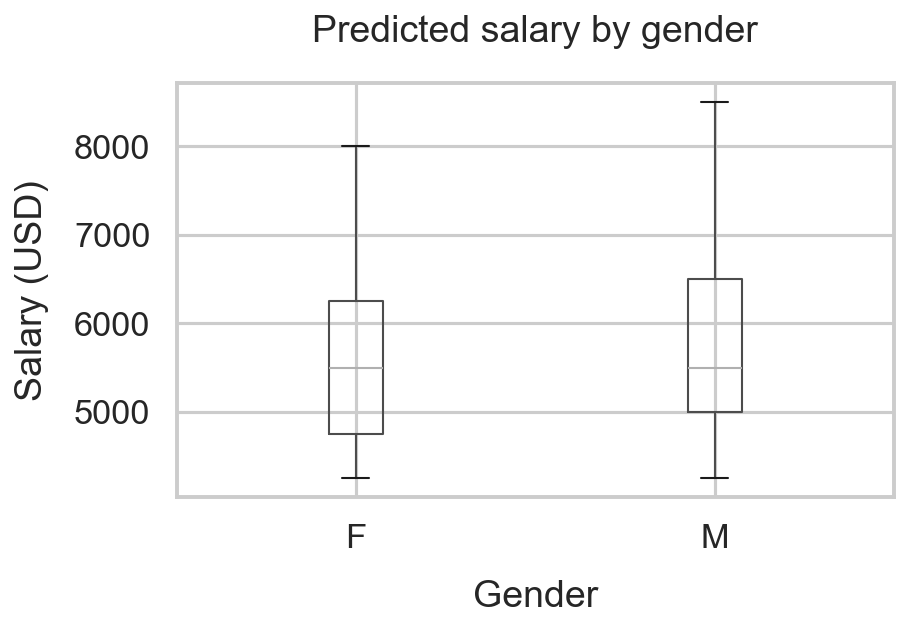

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Load the data
df = pd.read_csv('/Users/vitusthaulow/Downloads/02445 Datasheet.csv')

# Summary stats by gender
summary = (
    df.groupby('gender')['mean_salary']
    .agg(n='count', mean='mean', sd='std')
    .reset_index()
    .rename(columns={'gender': 'Gender'})
)

# Two‑sample t‑test (Welch’s, unequal variances)
male = df[df['gender'] == 'M']['mean_salary']
female = df[df['gender'] == 'F']['mean_salary']
t_stat, p_val = ttest_ind(male, female, equal_var=False)

# 3) Welch two-sample t-test
male    = df.loc[df["gender"] == "M", "mean_salary"]
female  = df.loc[df["gender"] == "F", "mean_salary"]

mean_salary_male = male.mean()
mean_salary_female = female.mean()
print(f"Mean salary for males: {mean_salary_male:.2f}")
print(f"Mean salary for females: {mean_salary_female:.2f}")

t_stat, p_val = ttest_ind(male, female, equal_var=False)
print(f"\nWelch’s t-test:  t = {t_stat:.3f},  p = {p_val:.4f}")

import matplotlib.pyplot as plt

df.boxplot(column="mean_salary", by="gender")
plt.title("Predicted salary by gender")
plt.suptitle("")          # drop the automatic super-title
plt.xlabel("Gender")
plt.ylabel("Salary (USD)")
plt.show()

Scriptet læser din CSV-fil, sikrer at kolonnerne for løn, alder, køn og job findes, gør køn og job til kategoriske variabler, log-transformerer lønnen for at udjævne skævhed og kører en multipel lineær regression:

Afhængig variabel: log(løn)

Forklarende variabler: alder (kontinuert), køn og jobkategori (faktorer)

Derefter:

Udskriver et fuldt regressions-resumé.

Fremhæver koefficienten for alder og omsætter den til procentvis lønstigning pr. ekstra leveår.

Tegner et residual-vs-fitted plot, så du hurtigt kan tjekke homoskedasticitet.

Kort sagt tester scriptet, om lønnen stiger med alderen, efter at der er taget højde for både køn og jobtitel, og giver dig både tal og et simpelt diagnostisk plot.


▶ First five rows of your data:
  gender  age  occupation_category  low_salary  high_salary  mean_salary
0      M   25                    1        4500         7500         6000
1      M   25                    1        5000         7500         6250
2      M   25                    1        4500         7500         6000
3      M   25                    1        4500         7500         6000
4      M   30                    1        5000         8000         6500 


=== Regression summary ===
                             OLS Regression Results                            
Dep. Variable:     np.log(mean_salary)   R-squared:                       0.899
Model:                             OLS   Adj. R-squared:                  0.896
Method:                  Least Squares   F-statistic:                     287.7
Date:                 Thu, 05 Jun 2025   Prob (F-statistic):           2.14e-93
Time:                         11:25:30   Log-Likelihood:                 280.32
No. Observations:  

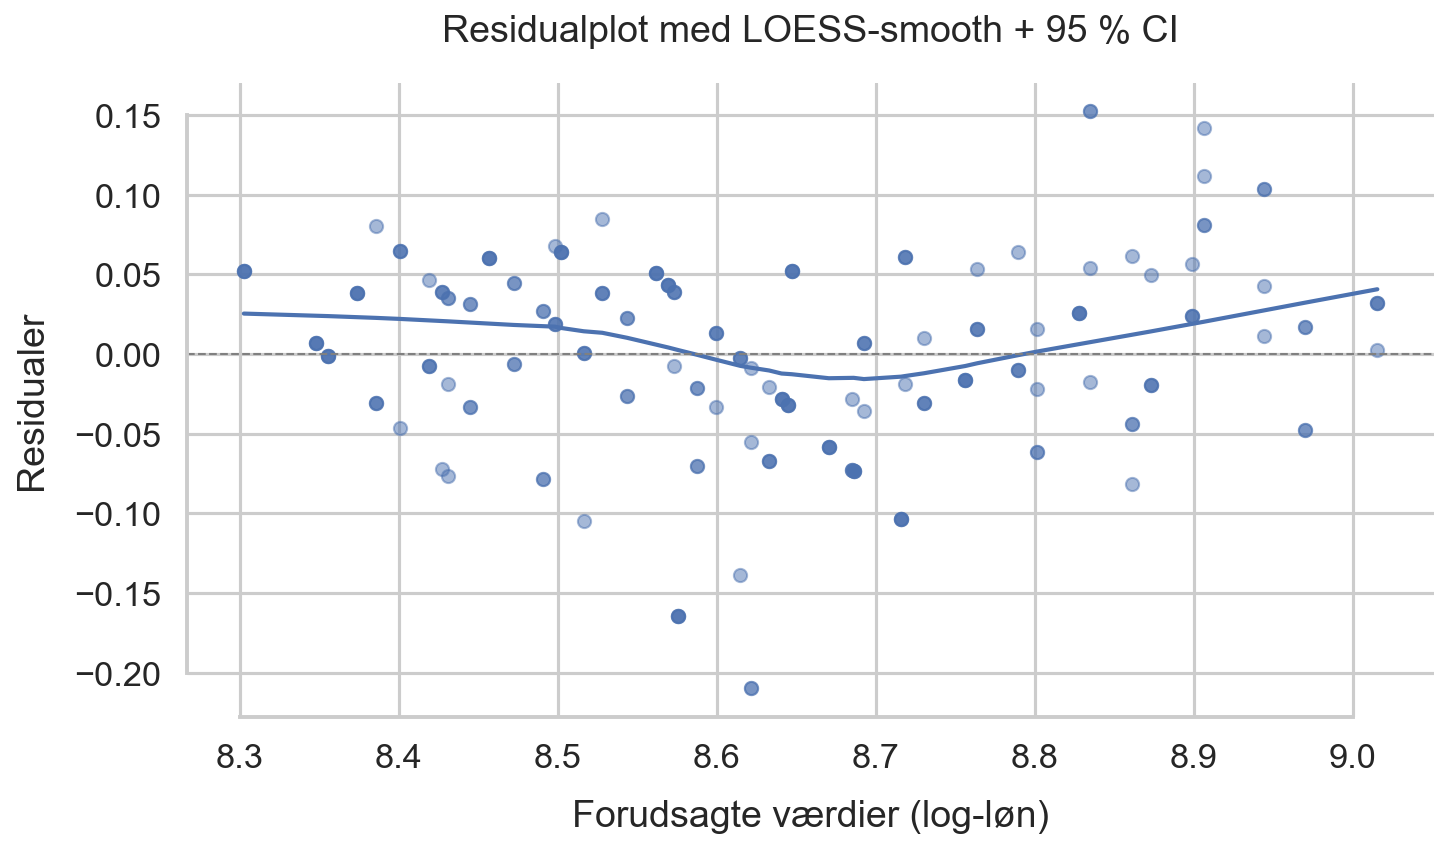

In [34]:
"""
analyse_salary_age.py
-----------------------------------------------------------
Checks whether salary rises with age *after* controlling for
job title and sex.

↳ Expected columns in your CSV:
   mean_salary   numeric  (monthly salary in DKK)
   age           numeric  (years)
   gender        string   ("M" / "F")
   job_title     string   (e.g. "Teacher")
-----------------------------------------------------------
"""

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sys

# ---------------------------------------------------------
# 1) LOAD DATA  (change the path/filename if needed)
# ---------------------------------------------------------
csv_path = "/Users/vitusthaulow/Downloads/02445 Datasheet.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    sys.exit(f"❌ Could not find the file: {csv_path}\n"
             "   → Check the path or rename the script’s csv_path variable.")

print("\n▶ First five rows of your data:")
print(df.head(), "\n")

# ---------------------------------------------------------
# 2) VERIFY EXPECTED COLUMNS ARE PRESENT
# ---------------------------------------------------------
required_cols = {"mean_salary", "age", "gender", "occupation_category"}
missing = required_cols - set(df.columns)
if missing:
    sys.exit(f"❌ Missing expected columns: {missing}\n"
             "   → Rename them in your CSV or adjust the formula below.")

# ---------------------------------------------------------
# 3) CAST CATEGORICALS EXPLICITLY  (good practice)
# ---------------------------------------------------------
df["gender"]    = df["gender"].astype("category")
df["occupation_category"] = df["occupation_category"].astype("category")

# ---------------------------------------------------------
# 4) MULTIPLE LINEAR REGRESSION
#    (log-transform salary to tame right-skew)
# ---------------------------------------------------------
formula = "np.log(mean_salary) ~ age + C(gender) + C(occupation_category)"
model   = smf.ols(formula, data=df).fit()

print("\n=== Regression summary ===")
print(model.summary())

# Focus on the age coefficient
coef_age = model.params["age"]
p_age    = model.pvalues["age"]
perc     = 100 * (np.exp(coef_age) - 1)   # back-transform from log-scale
print(f"\n➡  Each extra year of age changes salary by {perc:.2f}% "
      f"(β = {coef_age:.4f} on log-scale, p = {p_age:.4g}).")

# ---------------------------------------------------------
# 5) SIMPLE RESIDUAL-vs-FITTED PLOT  (homoscedasticity check)
# ---------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")  # talk = større fonte
plt.rcParams["figure.dpi"] = 150                 # højere opløsning

# ========= Plot =========
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(
    x=model.fittedvalues,
    y=model.resid,
    lowess=True,              # lokalt glidende gennemsnit
    scatter_kws={"alpha": 0.5, "s": 40},
    line_kws={"linewidth": 2},
    ax=ax
)

ax.axhline(0, ls="--", lw=1, c="grey")
ax.set_xlabel("Forudsagte værdier (log-løn)")
ax.set_ylabel("Residualer")
ax.set_title("Residualplot med LOESS-smooth + 95 % CI", pad=20)

sns.despine(trim=True)        # fjern top/højre kantlinje
plt.tight_layout()
plt.show()

Scriptet læser CSV-data, konverterer køn, alder og jobkategori til faktorer, log-transformerer lønnen, kører en 3-vejs ANOVA for at teste

om lønnen varierer mellem de fem jobkategorier,

om kønsforskellen ændrer sig på tværs af job (Sex × Job-interaktion),

kører automatisk Tukey-post-hoc, hvis jobeffekten er signifikant, og tegner et boxplot, der viser lønfordelingen for hver kombination af jobkategori og køn – alt sammen i én kompakt kodefil.

▶ Første rækker
   gender  age  occupation_category  low_salary  high_salary  mean_salary
0      M   25                    1        4500         7500         6000
1      M   25                    1        5000         7500         6250
2      M   25                    1        4500         7500         6000
3      M   25                    1        4500         7500         6000
4      M   30                    1        5000         8000         6500 


=== 3-vejs ANOVA (Type II) ===
                                           sum_sq     df           F  \
C(gender)                                0.102939    1.0   80.247550   
C(age)                                   2.135928    4.0  416.274643   
C(occupation_category)                   4.213381    4.0  821.153162   
C(gender):C(age)                         0.015900    4.0    3.098695   
C(gender):C(occupation_category)         0.024277    4.0    4.731300   
C(age):C(occupation_category)            0.296835   16.0   14.462673   
C(gende

/var/folders/xf/3h6xnmdj0jg__mms2zt6r6wc0000gn/T/ipykernel_9245/3568816698.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.groupby(["age", "gender"])["mean_salary"]


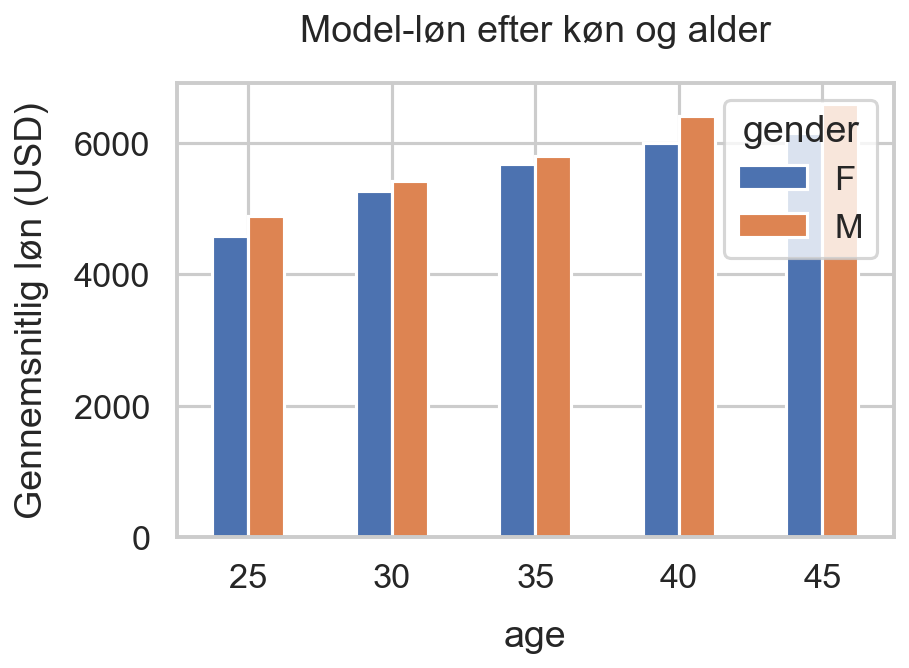

In [35]:
"""
anova_sex_age_job.py
------------------------------------------------------------
Tjekker om kønsforskellen i model-lønniveau ændrer sig
på tværs af både aldersgrupper og jobkategori.

CSV-krav (02445 Datasheet.csv)
------------------------------
gender               'M' / 'F'
age                  25, 30, 35, 40, 45  (diskrete trin)
occupation_category  1–5                 (numeriske koder)
mean_salary          månedsløn i DKK

Output
------
• Type-II 3-vejs ANOVA-tabel for
    C(gender) × C(age) × C(occupation_category)
• Klar besked om Sex × Age-interaktionen
• (Valgfri) søjlediagram med gennemsnitlig løn
    pr. køn inden for hver aldersgruppe
------------------------------------------------------------
"""

import sys
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm          # anova_lm
import matplotlib.pyplot as plt

CSV_PATH = "/Users/vitusthaulow/Downloads/02445 Datasheet.csv"      # ← ret hvis filen ligger andetsteds

# ----------------------------------------------------------
# 1) Indlæs data
# ----------------------------------------------------------
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    sys.exit(f"❌  Fandt ikke filen: {CSV_PATH}\n"
             "    Ret CSV_PATH eller flyt filen.")

print("▶ Første rækker\n", df.head(), "\n")

# ----------------------------------------------------------
# 2) Tjek forventede kolonner
# ----------------------------------------------------------
REQ = {"gender", "age", "occupation_category", "mean_salary"}
missing = REQ - set(df.columns)
if missing:
    sys.exit(f"❌  Mangler kolonner: {missing}\n"
             "    Ret kolonnenavne i CSV eller i scriptet.")

# ----------------------------------------------------------
# 3) Kategoriser variable & log-transformer løn
# ----------------------------------------------------------
df["gender"]              = df["gender"].astype("category")
df["age"]                 = df["age"].astype("category")            # behandles som faktor
df["occupation_category"] = df["occupation_category"].astype("category")

df["log_salary"] = np.log(df["mean_salary"])

# ----------------------------------------------------------
# 4) 3-vejs ANOVA-model
# ----------------------------------------------------------
formula = "log_salary ~ C(gender) * C(age) * C(occupation_category)"
model   = smf.ols(formula, data=df).fit()
anova_tbl = sm.stats.anova_lm(model, typ=2)     # Type-II SS

print("\n=== 3-vejs ANOVA (Type II) ===")
print(anova_tbl)

# ----------------------------------------------------------
# 5) Fokus på Sex × Age-interaktion
# ----------------------------------------------------------
p_sex_age = anova_tbl.loc["C(gender):C(age)", "PR(>F)"]
print(f"\n➡  Sex × Age interaktions-p = {p_sex_age:.4g}")

if p_sex_age < 0.05:
    print("   → Den kønsbestemte lønforskel varierer signifikant "
          "mellem aldersgrupper.")
else:
    print("   → Ingen signifikant evidens for, at løngabet ændrer sig "
          "mellem aldersgrupper.")

# ----------------------------------------------------------
# 6) Valgfrit: visuelt overblik
# ----------------------------------------------------------
plot_it = True
if plot_it:
    (df.groupby(["age", "gender"])["mean_salary"]
       .mean()
       .unstack("gender")
       .plot(kind="bar", rot=0))
    plt.ylabel("Gennemsnitlig løn (USD)")
    plt.title("Model-løn efter køn og alder")
    plt.tight_layout()
    plt.show()


Scriptet tester statistisk, om de fem jobkategorier giver forskellige lønforudsigelser, om mænd/kvinder behandles forskelligt inden for hvert job, og visualiserer resultatet.


=== 3-vejs ANOVA (Type II) ===
                                           sum_sq     df           F  \
C(gender)                                0.102939    1.0   80.247550   
C(age)                                   2.135928    4.0  416.274643   
C(occupation_category)                   4.213381    4.0  821.153162   
C(gender):C(age)                         0.015900    4.0    3.098695   
C(gender):C(occupation_category)         0.024277    4.0    4.731300   
C(age):C(occupation_category)            0.296835   16.0   14.462673   
C(gender):C(age):C(occupation_category)  0.075601   16.0    3.683501   
Residual                                 0.192415  150.0         NaN   

                                                PR(>F)  
C(gender)                                 1.199727e-15  
C(age)                                    4.297304e-80  
C(occupation_category)                   7.545586e-101  
C(gender):C(age)                          1.744179e-02  
C(gender):C(occupation_category)  

/var/folders/xf/3h6xnmdj0jg__mms2zt6r6wc0000gn/T/ipykernel_9245/772451291.py:84: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/xf/3h6xnmdj0jg__mms2zt6r6wc0000gn/T/ipykernel_9245/772451291.py:101: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(
/var/folders/xf/3h6xnmdj0jg__mms2zt6r6wc0000gn/T/ipykernel_9245/772451291.py:101: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


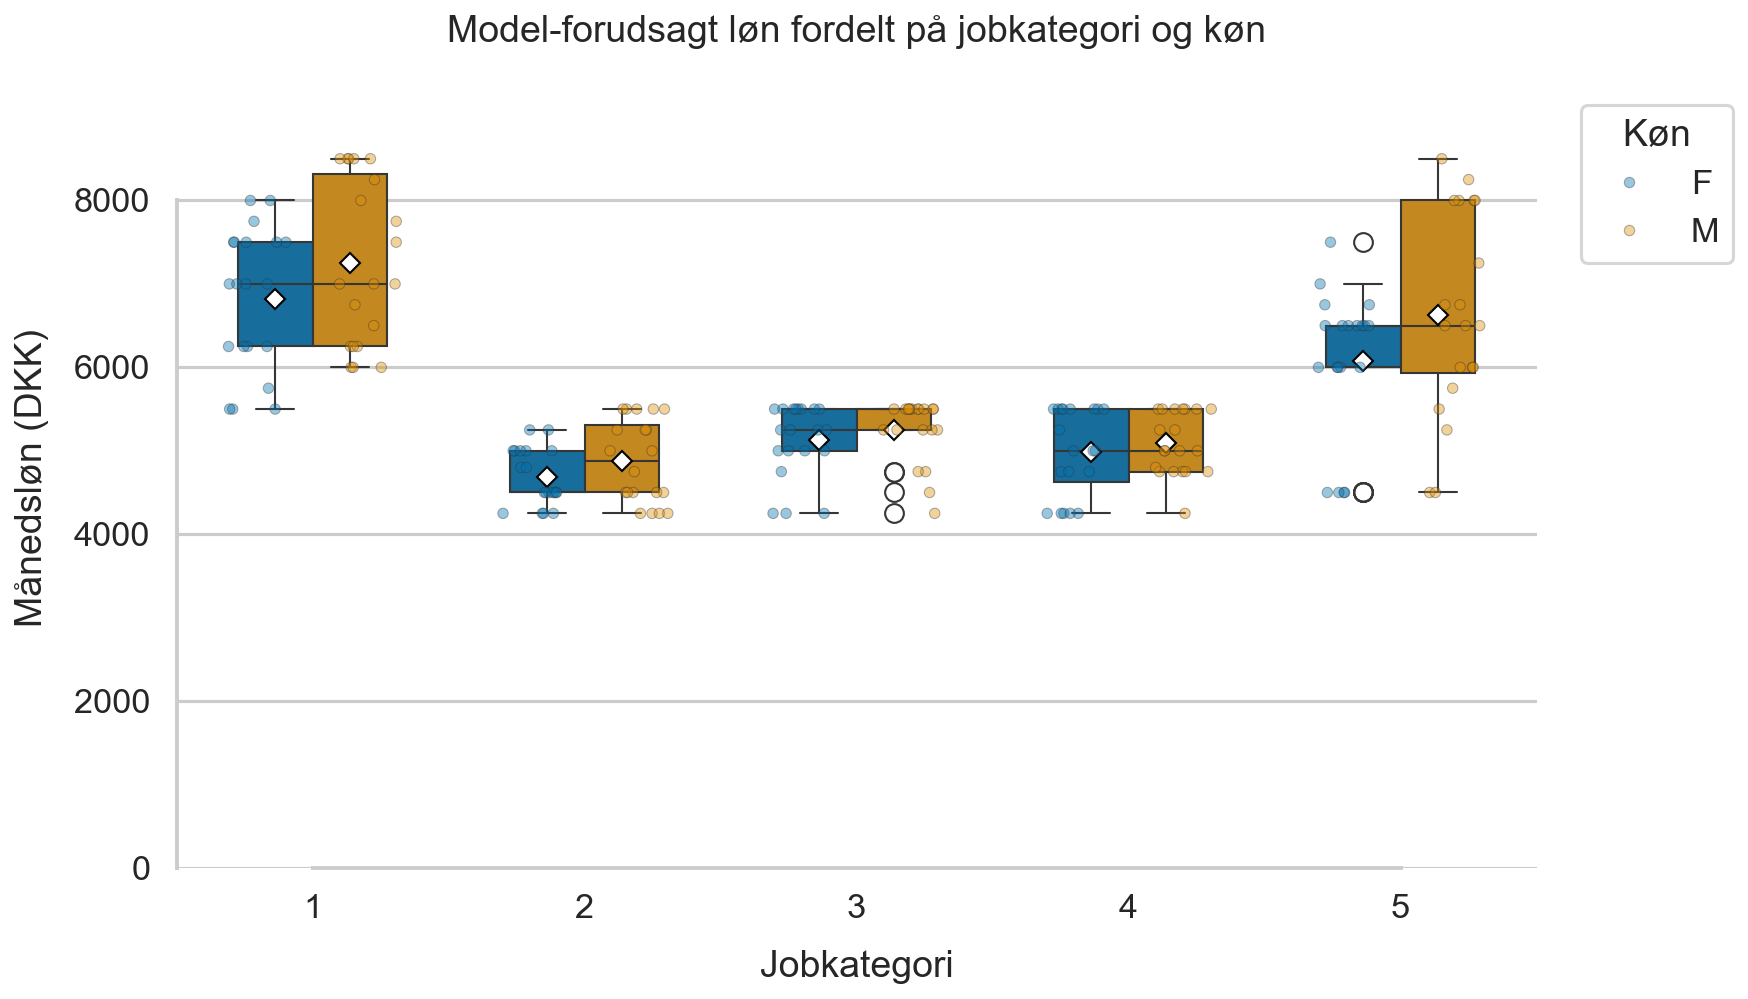

In [38]:
"""
anova_job_diff.py
------------------------------------------------------------
Tjekker om de fem jobkategorier giver forskellige
model-lønninger, og om kønsforskellen varierer på tværs af
job (Sex × Job-interaktion).

Kør sådan:
    pip install pandas numpy statsmodels matplotlib seaborn
    python anova_job_diff.py
------------------------------------------------------------
"""
import sys
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

CSV_PATH = "/Users/vitusthaulow/Downloads/02445 Datasheet.csv"  # ← ret hvis nødvendigt
alpha    = 0.05

# ------------------------------------------------------------------
# 1) Indlæs data
# ------------------------------------------------------------------
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    sys.exit(f"❌  Fil ikke fundet: {CSV_PATH}")

# ------------------------------------------------------------------
# 2) Datatyper
# ------------------------------------------------------------------
df["gender"]              = df["gender"].astype("category")
df["age"]                 = df["age"].astype("category")            # behandles som faktor
df["occupation_category"] = df["occupation_category"].astype("category")
df["log_salary"]          = np.log(df["mean_salary"])

# ------------------------------------------------------------------
# 3) 3-vejs ANOVA
# ------------------------------------------------------------------
formula   = "log_salary ~ C(gender) * C(age) * C(occupation_category)"
model     = smf.ols(formula, data=df).fit()
anova_tbl = sm.stats.anova_lm(model, typ=2)

print("\n=== 3-vejs ANOVA (Type II) ===")
print(anova_tbl)

# Hovedeffekt af jobkategori
p_job = anova_tbl.loc["C(occupation_category)", "PR(>F)"]
print(f"\n➡  Jobkategori-hovedeffektens p-værdi: {p_job:.4g}")

# Sex × Job-interaktion
p_sex_job = anova_tbl.loc["C(gender):C(occupation_category)", "PR(>F)"]
print(f"➡  Sex × Job-interaktions p-værdi: {p_sex_job:.4g}")

# ------------------------------------------------------------------
# 4) Post-hoc: Tukey HSD hvis jobeffekten er signifikant
# ------------------------------------------------------------------
if p_job < alpha:
    print(f"\n✔ Jobeffekten er signifikant (p < {alpha})."
          "  Kører Tukey HSD for parvise job-sammenligninger…")
    tukey = pairwise_tukeyhsd(
        endog=df["log_salary"],
        groups=df["occupation_category"],
        alpha=alpha
    )
    print(tukey.summary())
else:
    print("\n✖ Jobeffekten er ikke signifikant; springer post-hoc over.")

# ------------------------------------------------------------------
# 5) Flot plot: løn pr. job og køn
# ------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 150
palette = sns.color_palette("colorblind")

fig, ax = plt.subplots(figsize=(12, 7))

# (a) Box-plot m. gennemsnits-diamant
sns.boxplot(
    data=df,
    x="occupation_category", y="mean_salary",
    hue="gender",
    palette=palette,
    showmeans=True,
    meanprops={
        "marker": "D",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": 7
    },
    width=.55,
    ax=ax
)

# (b) Strip-plot (alle observationer)
sns.stripplot(
    data=df,
    x="occupation_category", y="mean_salary",
    hue="gender",
    dodge=True, jitter=.22,
    palette=palette, alpha=.4, linewidth=.5,
    marker="o", edgecolor="gray",
    ax=ax
)

# ----- kosmetik ----------------------------------------------------
ax.set_xlabel("Jobkategori")
ax.set_ylabel("Månedsløn (DKK)")
ax.set_title("Model-forudsagt løn fordelt på jobkategori og køn", pad=22)
ax.set_ylim(0, df["mean_salary"].max() * 1.1)  # luft i toppen

# Flet dobbelt-legend (fra box + strip) til én pæn legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    title="Køn", loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()